
Wykryto 11 epizodów bradykardii.
Bradykardia wykryta w okolicach 1008.97 sekundy.
Bradykardia wykryta w okolicach 1010.12 sekundy.
Bradykardia wykryta w okolicach 1011.27 sekundy.
Bradykardia wykryta w okolicach 1012.40 sekundy.
Bradykardia wykryta w okolicach 1021.77 sekundy.
Bradykardia wykryta w okolicach 1032.30 sekundy.
Bradykardia wykryta w okolicach 1033.14 sekundy.
Bradykardia wykryta w okolicach 1034.18 sekundy.
Bradykardia wykryta w okolicach 1035.10 sekundy.
Bradykardia wykryta w okolicach 1060.95 sekundy.
Bradykardia wykryta w okolicach 1062.13 sekundy.

Wykryto 0 epizodów tachykardii.


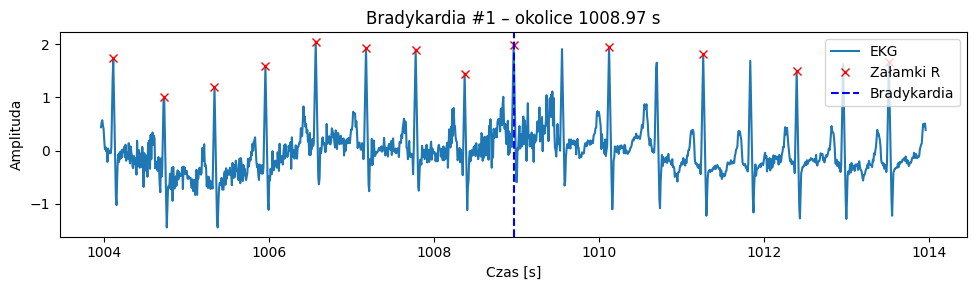

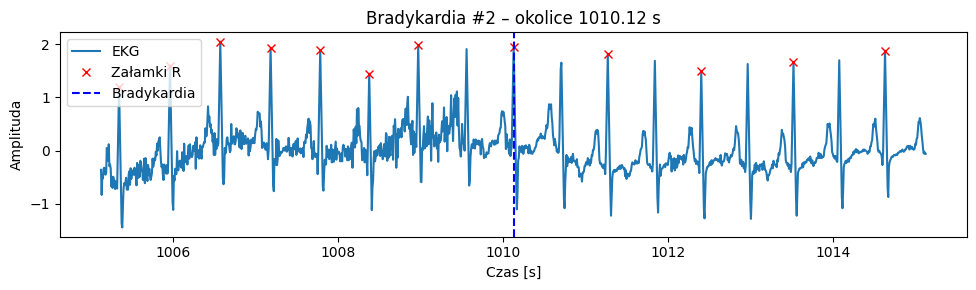

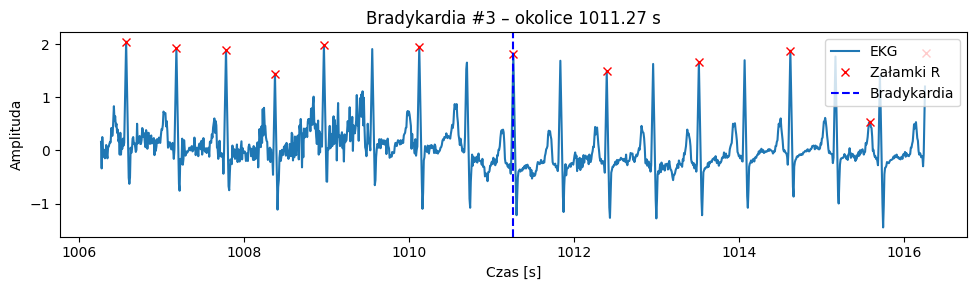

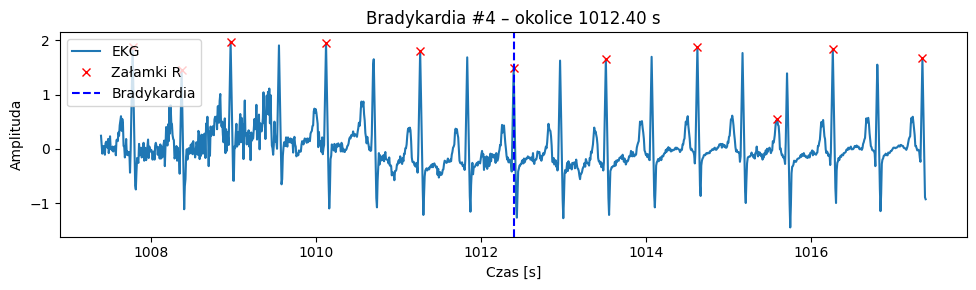

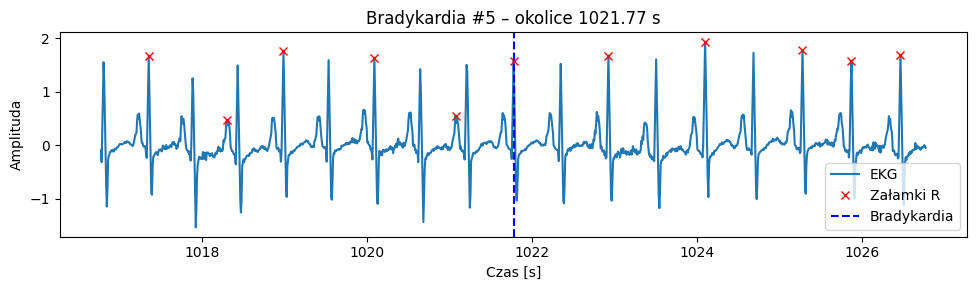

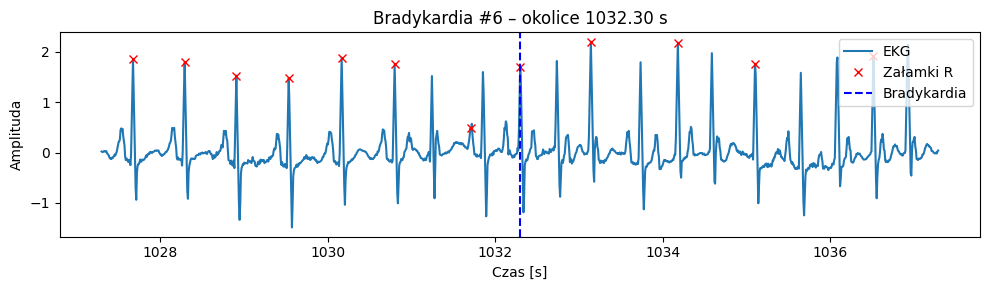

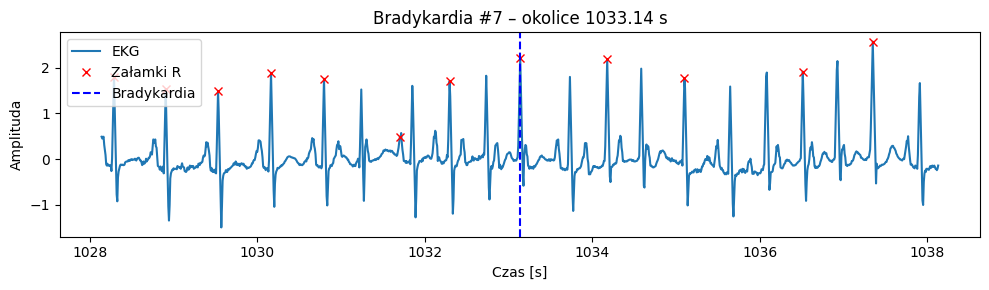

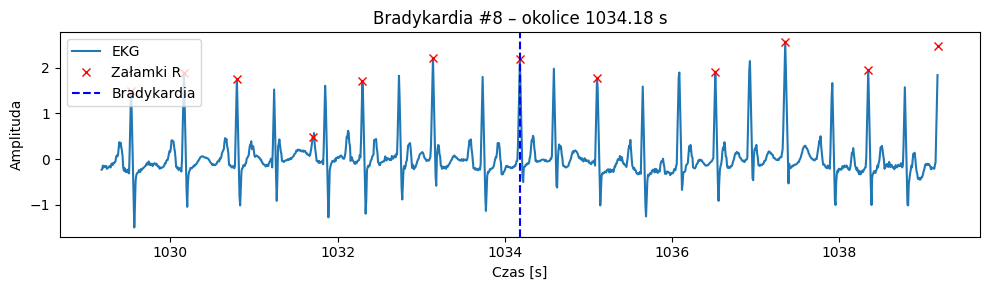

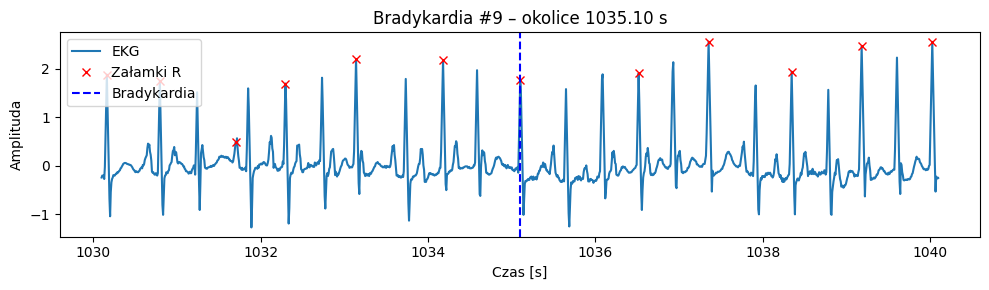

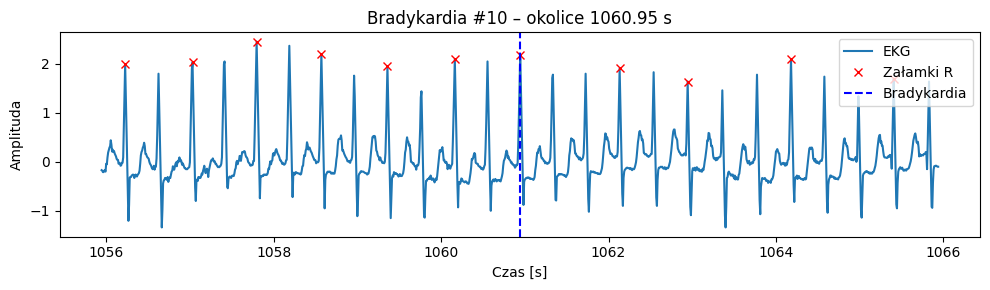

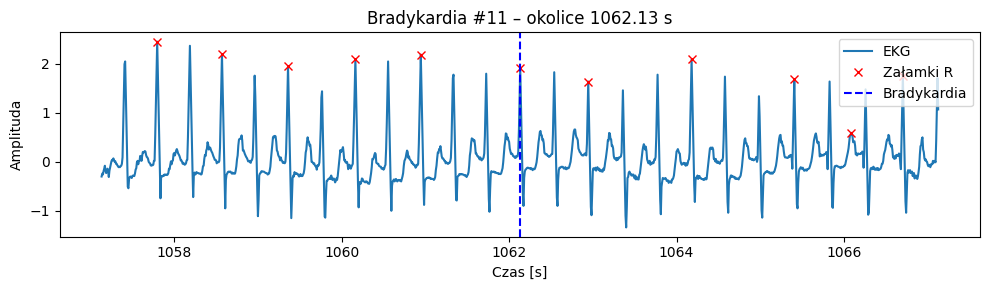

In [1]:
import wfdb
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def detect_r_peaks(signal, fs):
    distance = int(0.6 * fs)
    peaks, _ = find_peaks(signal, distance=distance, height=np.mean(signal))
    return peaks

def compute_rr_intervals(r_peaks, fs):
    return np.diff(r_peaks) / fs

def compute_heart_rate(rr_intervals):
    return 60 / rr_intervals

def detect_bradycardia(times, hr, window_duration=3.0, threshold=60):
    bradycardia_times = []
    for i in range(len(hr)):
        window_start = times[i]
        window_end = window_start + window_duration
        in_window = (times >= window_start) & (times <= window_end)
        if np.sum(in_window) > 0:
            avg_hr = np.mean(hr[in_window])
            if avg_hr < threshold:
                bradycardia_times.append(window_start)
    return bradycardia_times

def detect_tachycardia(times, hr, window_duration=3.0, threshold=100):
    tachycardia_times = []
    for i in range(len(hr)):
        window_start = times[i]
        window_end = window_start + window_duration
        in_window = (times >= window_start) & (times <= window_end)
        if np.sum(in_window) > 0:
            avg_hr = np.mean(hr[in_window])
            if avg_hr > threshold:
                tachycardia_times.append(window_start)
    return tachycardia_times


record_path = "testing/809"

record = wfdb.rdrecord(record_path)
fs = record.fs
signal = record.p_signal[:, 0]

r_peaks = detect_r_peaks(signal, fs)
r_peak_times = r_peaks / fs

rr_intervals = compute_rr_intervals(r_peaks, fs)
heart_rates = compute_heart_rate(rr_intervals)

bradycardia_onsets = detect_bradycardia(r_peak_times[:-1], heart_rates)
tachycardia_onsets = detect_tachycardia(r_peak_times[:-1], heart_rates)

print(f"\nWykryto {len(bradycardia_onsets)} epizodów bradykardii.")
for t in bradycardia_onsets:
    print(f"Bradykardia wykryta w okolicach {t:.2f} sekundy.")

print(f"\nWykryto {len(tachycardia_onsets)} epizodów tachykardii.")
for t in tachycardia_onsets:
    print(f"Tachykardia wykryta w okolicach {t:.2f} sekundy.")

window_sec = 5

def plot_events(events, color, label):
    for i, t in enumerate(events):
        start_idx = int(max((t - window_sec) * fs, 0))
        end_idx = int(min((t + window_sec) * fs, len(signal)))
        sig_segment = signal[start_idx:end_idx]
        r_in_segment = [p for p in r_peaks if start_idx <= p <= end_idx]
        r_segment_times = np.array(r_in_segment) / fs

        plt.figure(figsize=(10, 3))
        plt.plot(np.arange(start_idx, end_idx) / fs, sig_segment, label="EKG")
        plt.plot(r_segment_times, signal[r_in_segment], "rx", label="Załamki R")
        plt.axvline(x=t, color=color, linestyle='--', label=label)
        plt.title(f"{label} #{i+1} – okolice {t:.2f} s")
        plt.xlabel("Czas [s]")
        plt.ylabel("Amplituda")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_events(bradycardia_onsets, 'blue', 'Bradykardia')
plot_events(tachycardia_onsets, 'red', 'Tachykardia')

